**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import copy

#import data_loading_code as dlc

In [2]:
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

False
Using device: cpu


## Load data

In [3]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    # for index, row in data.iterrows():
    #     word_tokens = word_tokenize(row['Sentence'])
    #     filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
    #     df_.loc[len(df_)] = {
    #         "index": row['index'],
    #         "Class": row['Class'],
    #         "Sentence": " ".join(filtered_sent)
    #     }
    #return df_
    return data

small dataset

In [4]:
# get and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns) # pre-process

# split the data into training, validation, and test splits
# first get 50% for training
X_train, X_rest, y_train, y_rest = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=0,
    shuffle=True
)

# split rest to get 50/20/30 split
X_val, X_test, y_val, y_test = train_test_split(
    X_rest,
    y_rest,
    test_size=0.6,  # 60% of 50% = 30% test
    random_state=0,
    shuffle=True
)

large dataset

In [5]:
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)
data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = preprocess_pandas(data_large, columns)

X_train_l, X_rest_l, y_train_l, y_rest_l = train_test_split(
    data_large['Sentence'].values.astype('U'),
    data_large['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=42,
    shuffle=True
)

X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(
    X_rest_l, y_rest_l, test_size=0.6, random_state=42, shuffle=True
)

## Vectorise using tfidf

small dataset

In [6]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_vec = word_vectorizer.fit_transform(X_train).todense() # transform texts to sparse matrix and then to dense matrix for Pytorch
X_val_vec = word_vectorizer.transform(X_val).todense()
X_test_vec = word_vectorizer.transform(X_test).todense()

# convert to tensors
train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

# Build datasets and DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

large dataset

In [7]:
# vectorize data using TFIDF and transform for PyTorch for scalability
vectorizer_large = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_l_vec = vectorizer_large.fit_transform(X_train_l).todense()
X_val_l_vec = vectorizer_large.transform(X_val_l).todense()
X_test_l_vec = vectorizer_large.transform(X_test_l).todense()

# convert to tensors
train_x_tensor_l = torch.from_numpy(np.array(X_train_l_vec)).type(torch.FloatTensor)
train_y_tensor_l = torch.from_numpy(np.array(y_train_l)).type(torch.FloatTensor)
val_x_tensor_l = torch.from_numpy(np.array(X_val_l_vec)).type(torch.FloatTensor)
val_y_tensor_l = torch.from_numpy(np.array(y_val_l)).type(torch.FloatTensor)
test_x_tensor_l = torch.from_numpy(np.array(X_test_l_vec)).type(torch.FloatTensor)
test_y_tensor_l = torch.from_numpy(np.array(y_test_l)).type(torch.FloatTensor)

# build datasets and DataLoader
train_loader_large = DataLoader(TensorDataset(train_x_tensor_l, train_y_tensor_l), batch_size=32, shuffle=True)
val_loader_large = DataLoader(TensorDataset(val_x_tensor_l, val_y_tensor_l), batch_size=32, shuffle=False)
test_loader_large = DataLoader(TensorDataset(test_x_tensor_l, test_y_tensor_l), batch_size=32, shuffle=False)

## Sentence embeddings using Word2Vec for vectorization

In [8]:
# # load pretrained word2vec model with dimension 100
# word2vec_model = api.load("glove-wiki-gigaword-100")
# embedding_dim = 100 

In [9]:
sentences = list(X_train) + list(X_val) + list(X_test)

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

In [10]:
# Train Word2Vec 
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

In [11]:
# Function to convert sentences into embeddings
def sentence_to_vec(sentence, model, embedding_dim=100):
    words = sentence.split()
    vec = torch.zeros(embedding_dim)
    word_count = 0
    for word in words:
        if word in model.wv:
            vec += torch.tensor(model.wv[word])
            word_count += 1
    if word_count > 0:
        vec /= word_count
    return vec

# Convert all sentences to embeddings for the datasets
def create_dataset(X, y, word2vec_model, embedding_dim=100):
    x_tensor = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X])
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Binary labels as float32
    return x_tensor, y_tensor

small dataset

In [12]:
# # Convert all sentences to embeddings for the datasets
# train_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_train])
# train_y_tensor_w2v = torch.tensor(y_train, dtype=torch.float32)  # Binary labels as float32

# val_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_val])
# val_y_tensor_w2v = torch.tensor(y_val, dtype=torch.float32)

# test_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_test])
# test_y_tensor_w2v = torch.tensor(y_test, dtype=torch.float32)

# Create Tensor datasets
train_x_tensor_w2v, train_y_tensor_w2v = create_dataset(X_train, y_train, word2vec_model)
val_x_tensor_w2v, val_y_tensor_w2v = create_dataset(X_val, y_val, word2vec_model)
test_x_tensor_w2v, test_y_tensor_w2v = create_dataset(X_test, y_test, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v = DataLoader(TensorDataset(train_x_tensor_w2v, train_y_tensor_w2v), batch_size=32, shuffle=True)
val_loader_w2v = DataLoader(TensorDataset(val_x_tensor_w2v, val_y_tensor_w2v), batch_size=32, shuffle=False)
test_loader_w2v = DataLoader(TensorDataset(test_x_tensor_w2v, test_y_tensor_w2v), batch_size=32, shuffle=False)

large dataset

In [13]:
# Create Tensor datasets
train_x_tensor_w2v_l, train_y_tensor_w2v_l = create_dataset(X_train_l, y_train_l, word2vec_model)
val_x_tensor_w2v_l, val_y_tensor_w2v_l = create_dataset(X_val_l, y_val_l, word2vec_model)
test_x_tensor_w2v_l, test_y_tensor_w2v_l = create_dataset(X_test_l, y_test_l, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v_l = DataLoader(TensorDataset(train_x_tensor_w2v_l, train_y_tensor_w2v_l), batch_size=32, shuffle=True)
val_loader_w2v_l = DataLoader(TensorDataset(val_x_tensor_w2v_l, val_y_tensor_w2v_l), batch_size=32, shuffle=False)
test_loader_w2v_l = DataLoader(TensorDataset(test_x_tensor_w2v_l, test_y_tensor_w2v_l), batch_size=32, shuffle=False)

---

# ANN Classifier

In [14]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [15]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [16]:
class ANNClassifierLarge(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifierLarge, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

In [17]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [18]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

---

# Training and Evaluation of ANNs

## Train simple ANN Classifier on small dataset

In [19]:
model_name ='amazonclasssimple'
input_size = train_x_tensor.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7556, Val Loss: 0.7022, Train Acc: 51.80%, Val Acc: 47.00%
Epoch 2/250, Train Loss: 0.7545, Val Loss: 0.6935, Train Acc: 52.00%, Val Acc: 50.00%
Epoch 3/250, Train Loss: 0.6989, Val Loss: 0.6723, Train Acc: 55.60%, Val Acc: 61.00%
Epoch 4/250, Train Loss: 0.6735, Val Loss: 0.6577, Train Acc: 60.40%, Val Acc: 61.00%
Epoch 5/250, Train Loss: 0.6251, Val Loss: 0.6515, Train Acc: 62.40%, Val Acc: 62.00%
Epoch 6/250, Train Loss: 0.6234, Val Loss: 0.6425, Train Acc: 65.00%, Val Acc: 65.00%
Epoch 7/250, Train Loss: 0.6116, Val Loss: 0.6417, Train Acc: 66.80%, Val Acc: 67.00%
Epoch 8/250, Train Loss: 0.5578, Val Loss: 0.6319, Train Acc: 70.80%, Val Acc: 68.00%
Epoch 9/250, Train Loss: 0.5764, Val Loss: 0.6276, Train Acc: 70.60%, Val Acc: 70.00%
Epoch 10/250, Train Loss: 0.5604, Val Loss: 0.6235, Train Acc: 72.40%, Val Acc: 70.50%
Epoch 11/250, Train Loss: 0.5566, Val Loss: 0.6173, Train Acc: 72.20%, Val Acc: 70.00%
Epoch 12/250, Train Loss: 0.5415, Val Loss: 0.6157, 

Accuracy on testing dataset: 79.33333333333333%
F1-Score: 0.81


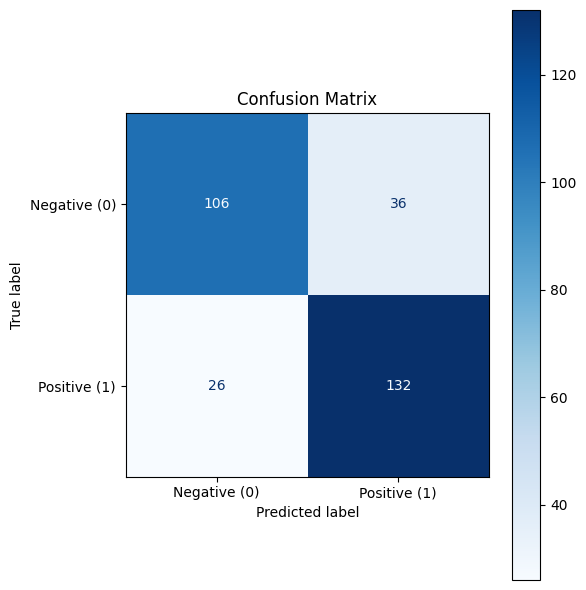

In [20]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train simple ANN Classifier on large dataset

In [21]:
model_name ='amazonclasssimplelarge'
input_size = train_x_tensor_l.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6132, Val Loss: 0.5011, Train Acc: 62.66%, Val Acc: 84.08%
Epoch 2/25, Train Loss: 0.5210, Val Loss: 0.4569, Train Acc: 72.58%, Val Acc: 86.52%
Epoch 3/25, Train Loss: 0.4708, Val Loss: 0.4224, Train Acc: 79.40%, Val Acc: 87.28%
Epoch 4/25, Train Loss: 0.4380, Val Loss: 0.3969, Train Acc: 84.53%, Val Acc: 87.66%
Epoch 5/25, Train Loss: 0.4081, Val Loss: 0.3782, Train Acc: 83.27%, Val Acc: 87.66%
Epoch 6/25, Train Loss: 0.3843, Val Loss: 0.3570, Train Acc: 82.94%, Val Acc: 87.80%
Epoch 7/25, Train Loss: 0.3577, Val Loss: 0.3403, Train Acc: 82.73%, Val Acc: 87.88%
Epoch 8/25, Train Loss: 0.3466, Val Loss: 0.3240, Train Acc: 82.35%, Val Acc: 88.56%
Epoch 9/25, Train Loss: 0.3303, Val Loss: 0.3119, Train Acc: 82.79%, Val Acc: 88.50%
Epoch 10/25, Train Loss: 0.3121, Val Loss: 0.3081, Train Acc: 83.30%, Val Acc: 88.26%
Epoch 11/25, Train Loss: 0.3051, Val Loss: 0.3050, Train Acc: 83.22%, Val Acc: 88.36%
Epoch 12/25, Train Loss: 0.2910, Val Loss: 0.2942, Train Acc: 8

Accuracy on testing dataset: 88.30666666666667%
F1-Score: 0.90


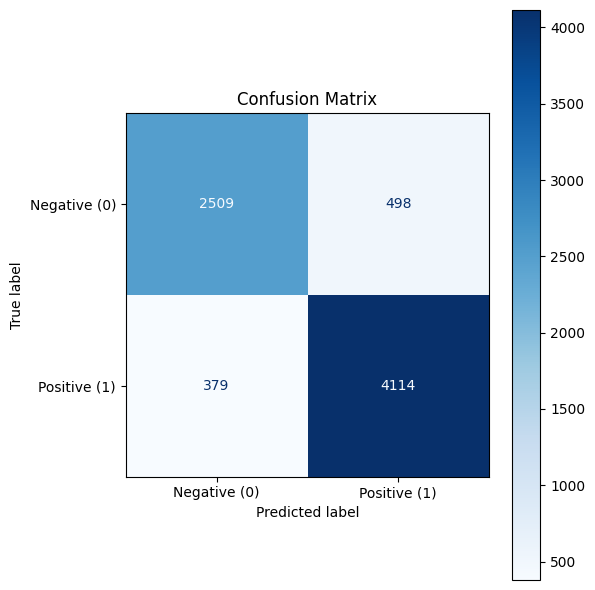

In [22]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on large dataset

In [23]:
model_name_l = 'amazonclasslarge'
input_size = train_x_tensor_l.shape[1]
model = ANNClassifier(input_size, model_name_l)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6578, Val Loss: 0.5345, Train Acc: 51.32%, Val Acc: 84.14%
Epoch 2/25, Train Loss: 0.4966, Val Loss: 0.4087, Train Acc: 79.21%, Val Acc: 86.38%
Epoch 3/25, Train Loss: 0.3635, Val Loss: 0.3484, Train Acc: 88.58%, Val Acc: 86.24%
Epoch 4/25, Train Loss: 0.2807, Val Loss: 0.3213, Train Acc: 90.43%, Val Acc: 87.50%
Epoch 5/25, Train Loss: 0.2365, Val Loss: 0.3260, Train Acc: 92.26%, Val Acc: 86.66%
Epoch 6/25, Train Loss: 0.2050, Val Loss: 0.3470, Train Acc: 92.63%, Val Acc: 86.22%
Epoch 7/25, Train Loss: 0.1856, Val Loss: 0.3725, Train Acc: 92.85%, Val Acc: 86.06%
Epoch 8/25, Train Loss: 0.1839, Val Loss: 0.3934, Train Acc: 92.90%, Val Acc: 85.94%
Epoch 9/25, Train Loss: 0.1788, Val Loss: 0.4166, Train Acc: 92.77%, Val Acc: 85.88%
Epoch 10/25, Train Loss: 0.1912, Val Loss: 0.4294, Train Acc: 91.91%, Val Acc: 86.38%
Epoch 11/25, Train Loss: 0.1979, Val Loss: 0.4332, Train Acc: 91.99%, Val Acc: 86.58%
Epoch 12/25, Train Loss: 0.1944, Val Loss: 0.4263, Train Acc: 9

Accuracy on testing dataset: 87.32%
F1-Score: 0.89


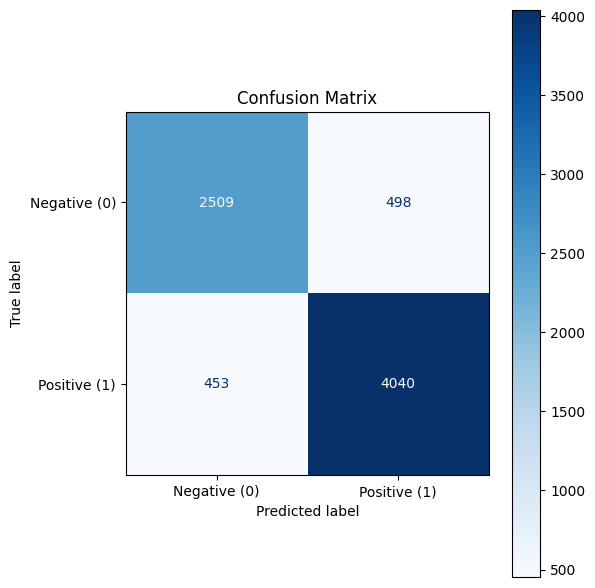

In [24]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

## Train ANN with word embeddings
small dataset and small model

In [25]:
model_name ='amazonclasssimplew2v'
input_size = train_x_tensor_w2v.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v, val_loader_w2v, num_epochs=500)

Epoch 1/500, Train Loss: 0.7178, Val Loss: 0.6884, Train Acc: 51.00%, Val Acc: 53.00%
Epoch 2/500, Train Loss: 0.7190, Val Loss: 0.6885, Train Acc: 51.20%, Val Acc: 53.00%
Epoch 3/500, Train Loss: 0.7298, Val Loss: 0.6893, Train Acc: 51.20%, Val Acc: 53.00%
Epoch 4/500, Train Loss: 0.7177, Val Loss: 0.6879, Train Acc: 52.00%, Val Acc: 53.00%
Epoch 5/500, Train Loss: 0.7270, Val Loss: 0.6872, Train Acc: 48.60%, Val Acc: 53.00%
Epoch 6/500, Train Loss: 0.7113, Val Loss: 0.6879, Train Acc: 53.00%, Val Acc: 53.00%
Epoch 7/500, Train Loss: 0.7050, Val Loss: 0.6918, Train Acc: 51.80%, Val Acc: 53.00%
Epoch 8/500, Train Loss: 0.7166, Val Loss: 0.6930, Train Acc: 51.00%, Val Acc: 53.00%
Epoch 9/500, Train Loss: 0.7026, Val Loss: 0.6922, Train Acc: 48.00%, Val Acc: 53.00%
Epoch 10/500, Train Loss: 0.6953, Val Loss: 0.6900, Train Acc: 52.60%, Val Acc: 53.50%
Epoch 11/500, Train Loss: 0.7016, Val Loss: 0.6888, Train Acc: 50.00%, Val Acc: 53.00%
Epoch 12/500, Train Loss: 0.7081, Val Loss: 0.6869, 

Accuracy on testing dataset: 58.0%
F1-Score: 0.50


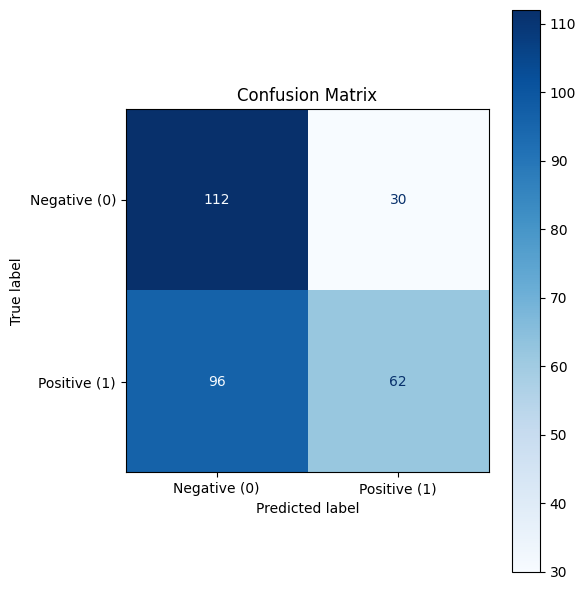

In [26]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

larger dataset and larger model

In [27]:
model_name ='amazonclasssimplew2vlarge'
input_size = train_x_tensor_w2v_l.shape[1]
model = ANNClassifierLarge(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v_l, val_loader_w2v_l, num_epochs=50)

Epoch 1/50, Train Loss: 0.6673, Val Loss: 0.6501, Train Acc: 60.59%, Val Acc: 60.98%
Epoch 2/50, Train Loss: 0.6314, Val Loss: 0.6497, Train Acc: 64.10%, Val Acc: 60.96%
Epoch 3/50, Train Loss: 0.6114, Val Loss: 0.9772, Train Acc: 66.22%, Val Acc: 60.86%
Epoch 4/50, Train Loss: 0.5972, Val Loss: 0.9667, Train Acc: 67.62%, Val Acc: 61.00%
Epoch 5/50, Train Loss: 0.5871, Val Loss: 1.4241, Train Acc: 69.18%, Val Acc: 60.90%
Epoch 6/50, Train Loss: 0.5912, Val Loss: 0.6234, Train Acc: 68.32%, Val Acc: 64.38%
Epoch 7/50, Train Loss: 0.5878, Val Loss: 0.6887, Train Acc: 68.96%, Val Acc: 53.48%
Epoch 8/50, Train Loss: 0.5899, Val Loss: 0.8621, Train Acc: 68.50%, Val Acc: 61.18%
Epoch 9/50, Train Loss: 0.5876, Val Loss: 0.8690, Train Acc: 69.08%, Val Acc: 42.56%
Epoch 10/50, Train Loss: 0.5790, Val Loss: 1.2985, Train Acc: 69.23%, Val Acc: 39.34%
Epoch 11/50, Train Loss: 0.5806, Val Loss: 0.6460, Train Acc: 69.30%, Val Acc: 62.08%
Epoch 12/50, Train Loss: 0.5840, Val Loss: 0.5972, Train Acc: 6

Accuracy on testing dataset: 72.92%
F1-Score: 0.78


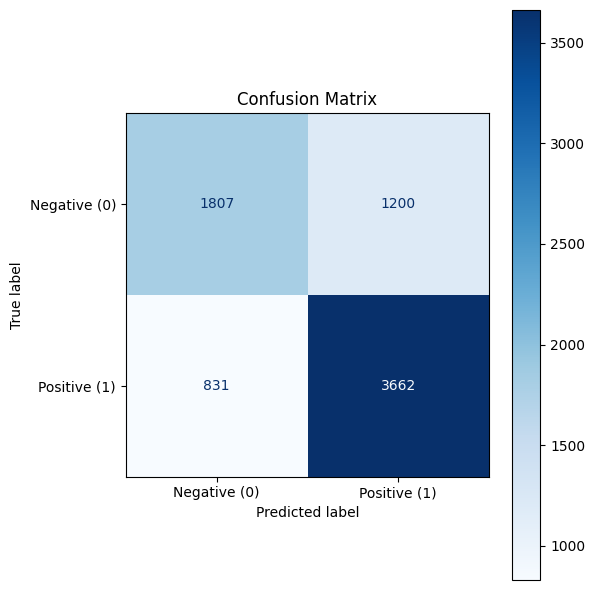

In [28]:
# Load best model
model = ANNClassifierLarge(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

# Transformer